##### **Imports**

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import quad
from scipy.stats import expon, norm
from scipy.optimize import minimize
from matplotlib.ticker import AutoMinorLocator
import seaborn as sns
from sklearn.neighbors import KernelDensity

colors = ['crimson','midnightblue', 'magenta','orange','springgreen','dodgerblue','darkviolet', 'olive','tomato']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

##### **Problem 2a**

Get the data

In [28]:
columns_to_extract = ['lon', 'lat', 'crash_date']
dataframe = pd.read_csv('cpd-crash-incidents.csv', sep=';',usecols=columns_to_extract)

In [4]:
nan_count = dataframe['lon'].isna().sum()
non_nan_count = dataframe['lon'].notna().sum()

print(f"Number of NaN values is: {nan_count}")
print(f"Number of non-NaN values is: {non_nan_count}")

Number of NaN values is: 16779
Number of non-NaN values is: 6679


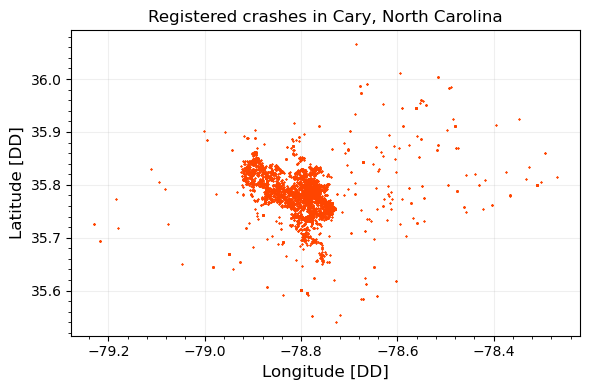

In [5]:
plt.figure(figsize = (6,4))

plt.scatter(dataframe['lon'],dataframe['lat'],s=0.5,marker='x',color='orangered')

ax = plt.gca()
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.tick_params(which='minor', length=2, color='k')

plt.title(f'Registered crashes in Cary, North Carolina',fontsize=12)
plt.xlabel('Longitude [DD]',fontsize=12)
plt.ylabel('Latitude [DD]',fontsize=12)
plt.grid(True,alpha=0.2,zorder=0)
ax.set_axisbelow(True)
plt.tight_layout()
plt.savefig('Problem2_Fig2a.pdf')
plt.show()

In [6]:
dataframe['crash_date'] = pd.to_datetime(dataframe['crash_date'])
dataframe['time_as_number'] = dataframe['crash_date'].dt.hour + dataframe['crash_date'].dt.minute/60 + dataframe['crash_date'].dt.second/3600

In [7]:
crashes_over_time = dataframe['time_as_number']

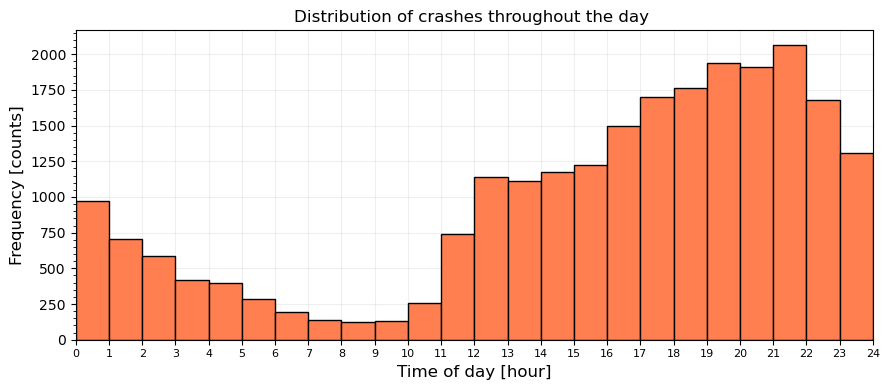

In [8]:
plt.figure(figsize = (9,4))

plt.hist(crashes_over_time,bins=np.arange(0,25,1),color='coral',edgecolor='black')

ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.tick_params(which='minor', length=2, color='k')

plt.title(f'Distribution of crashes throughout the day ',fontsize=12)
plt.xlim(0,24)
plt.xticks(range(25), [str(i) for i in range(25)],fontsize=8)
plt.xlabel('Time of day [hour]',fontsize=12)
plt.ylabel('Frequency [counts]',fontsize=12)
plt.grid(True,alpha=0.2,zorder=0)
ax.set_axisbelow(True)
plt.tight_layout()
plt.savefig('Problem2_Fig2a_2.pdf')
plt.show()

##### Problem 2b

In [9]:
def epanechnikov_kernel(u):
    return 0.75 * (1 - u**2) if np.abs(u) <= 1 else 0

def circular_distance(time_point1, time_point2, cycle_length=24):
    distance = np.abs(time_point1 - time_point2)
    distance = np.minimum(distance, cycle_length - distance)
    return distance

def epanechnikov_KDE(data, x, bandwidth):
    N = len(data)
    cycle_length = 24
    estimate = np.sum([epanechnikov_kernel(circular_distance(x, xi, cycle_length) / bandwidth) for xi in data]) / (N * bandwidth)
    return estimate

In [10]:
h = 0.8 # Bandwidth

x_values = np.linspace(min(crashes_over_time) - h, max(crashes_over_time) + h, 1000)
density_estimates = [epanechnikov_KDE(crashes_over_time, x, h) for x in x_values]

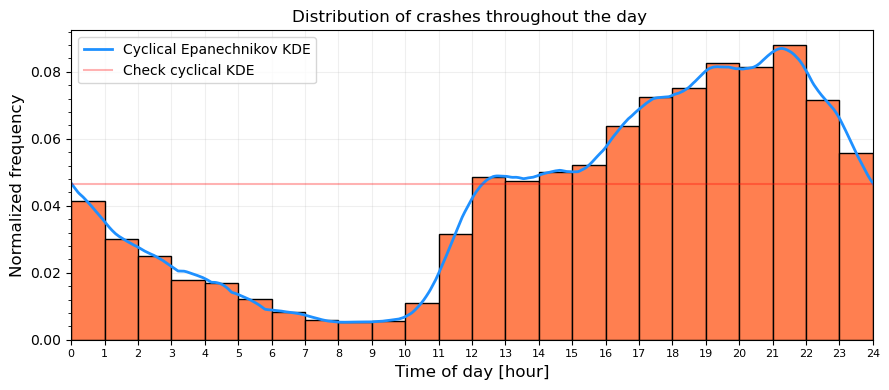

In [27]:
plt.figure(figsize = (9,4))

plt.hist(crashes_over_time,bins=np.arange(0,25,1),density=True,color='coral',edgecolor='black')
plt.plot(x_values, density_estimates, label='Cyclical Epanechnikov KDE',color = 'dodgerblue',linewidth=2)
plt.axhline(y=density_estimates[32],color = 'red',alpha=0.3,label='Check cyclical KDE')

ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.tick_params(which='minor', length=2, color='k')

plt.title(f'Distribution of crashes throughout the day ',fontsize=12)
plt.xlim(0,24)
plt.xticks(range(25), [str(i) for i in range(25)],fontsize=8)
plt.xlabel('Time of day [hour]',fontsize=12)
plt.ylabel('Normalized frequency',fontsize=12)
plt.grid(True,alpha=0.2,zorder=0)
ax.set_axisbelow(True)
plt.tight_layout()
plt.legend(loc='best')
plt.savefig('Problem2_Fig2b.pdf')
plt.show()

In [12]:
times_to_evaluate = ["00:23", "01:49", "08:12", "15:55", "18:02", "21:12", "23:44"]
times_in_hours = [int(t.split(':')[0]) + int(t.split(':')[1]) / 60 for t in times_to_evaluate]
pdf_estimates = {t: epanechnikov_KDE(crashes_over_time, x, h) for t, x in zip(times_to_evaluate, times_in_hours)}

In [13]:
pdf_estimates

{'00:23': 0.04229811874026686,
 '01:49': 0.028548648280953284,
 '08:12': 0.005227371383353176,
 '15:55': 0.0564570251719829,
 '18:02': 0.07313700360867541,
 '21:12': 0.08688749578717245,
 '23:44': 0.051230008566087754}

In [14]:
def find_best_patrol_window(density_estimates, interval_length=2, total_hours=24):
    points_per_hour = len(density_estimates) / total_hours
    interval_points = int(points_per_hour * interval_length)    
    max_density_sum = 0
    best_interval_start_index = 0
    for i in range(len(density_estimates) - interval_points + 1):
        current_density_sum = np.sum(density_estimates[i:i+interval_points])
        if current_density_sum > max_density_sum:
            max_density_sum = current_density_sum
            best_interval_start_index = i

    reduction_amount = max_density_sum * 0.1

    total_density = np.sum(density_estimates)
    reduction_percentage = (reduction_amount / total_density) * 100

    best_interval_start_time = (best_interval_start_index / points_per_hour) % total_hours
    best_interval_end_time = (best_interval_start_time + interval_length) % total_hours
    return best_interval_start_time, best_interval_end_time, reduction_percentage

best_start_time, best_end_time, percent_reduction = find_best_patrol_window(density_estimates)

(19.344, 21.344, 1.650477165792976)

In [45]:
print(f'The best start time for police patrol would be {best_start_time}, where we can reduce crashes by {percent_reduction:.03}%')

The best start time for police patrol would be 19.344, where we can reduce crashes by 1.65%


##### Problem 2C

In [75]:
def kde2D(x, y, bandwidth, xbins=1000j, ybins=1000j): 

    xx, yy = np.mgrid[x.min():x.max():xbins, 
                      y.min():y.max():ybins]

    xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T
    xy_train  = np.vstack([y, x]).T

    kde_skl = KernelDensity(bandwidth=bandwidth,kernel='epanechnikov')
    kde_skl.fit(xy_train)

    z = np.exp(kde_skl.score_samples(xy_sample))
    return xx, yy, np.reshape(z, xx.shape)

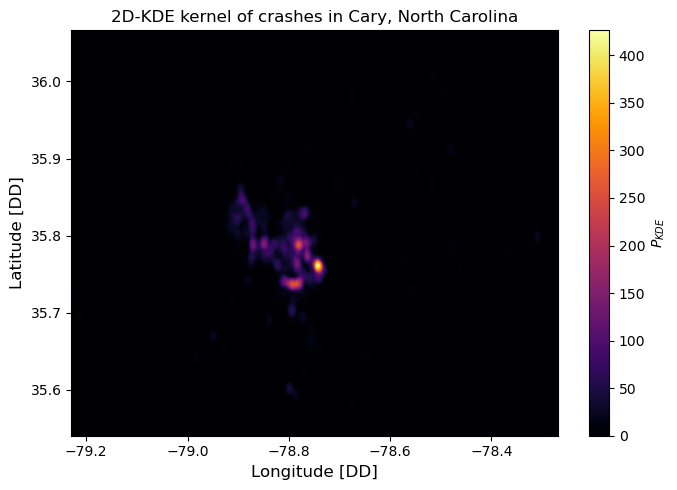

In [76]:
dataframe = dataframe.dropna()

xx, yy, zz = kde2D(dataframe['lon'], dataframe['lat'], 0.01)

plt.figure(figsize = (7,5))
plt.pcolormesh(xx, yy, zz)
color_mesh = plt.pcolormesh(xx, yy, zz, shading='auto',cmap='inferno')
cbar = plt.colorbar(color_mesh)
cbar.set_label(r'$P_{KDE}$')

plt.title(f'2D-KDE kernel of crashes in Cary, North Carolina',fontsize=12)
plt.xlabel('Longitude [DD]',fontsize=12)
plt.ylabel('Latitude [DD]',fontsize=12)
plt.tight_layout()
plt.savefig('Problem2_Fig2c.pdf')
plt.show()

Estimating the box

In [96]:
def integrate_kde_box(xx, yy, zz, lon_min, lon_max, lat_min, lat_max):
    lon_idx = (xx >= lon_min) & (xx <= lon_max)
    lat_idx = (yy >= lat_min) & (yy <= lat_max)
    box_idx = lon_idx & lat_idx

    kde_sum_within_box = zz[box_idx].sum()
    
    total_kde_sum = zz.sum()
    
    percentage = (kde_sum_within_box / total_kde_sum) * 100
    return percentage

lon_min = -78.76
lon_max = -78.72
lat_min = 35.74
lat_max = 35.78

percentage = integrate_kde_box(xx, yy, zz, lon_min, lon_max, lat_min, lat_max)
print(f'{percentage:.4}% of the crashes are found within the box')

13.88% of the crashes are found within the box
